In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Q3 API
from layers import dense 

In [4]:
dataset = np.load('a1_dataset.npz')
dataset.files

['x', 'y']

In [5]:
# 80-10-10 split for train, validate and test images
train_till = int(.8 * dataset['x'].shape[0])
validate_till = int(.9 * dataset['x'].shape[0])

print(train_till, validate_till-train_till, dataset['x'].shape[0]-validate_till)

# training dataset
x_train = dataset['x'][:train_till]/255
y_train = np.eye(96)[dataset['y'][:train_till]]

# validation dataset
x_val = dataset['x'][train_till:validate_till]/255
y_val = np.eye(96)[dataset['y'][train_till:validate_till]]

# testing dataset
x_test = dataset['x'][validate_till:]/255
y_test = np.eye(96)[dataset['y'][validate_till:]]

76800 9600 9600


In [6]:
n_classes = 96
n_features = 2352
batch_size = 25
epochs = 30
learning_rate = 0.3

In [7]:
# input
x_p = tf.placeholder(tf.float32, [None, n_features])
# output
y_p = tf.placeholder(tf.float32, [None, n_classes])

In [8]:
# define architecture
n_l1 = 192

# set up layers
hidden1 = dense(x=x_p, in_length=n_features, neurons=n_l1, activation=tf.nn.relu, layer_name='Layer_1', wdev=0.03)
output = dense(x=hidden1, in_length=n_l1, neurons=n_classes, activation=tf.nn.softmax, layer_name='Layer_Output', wdev=0.03)
y_clipped = tf.clip_by_value(output, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y_p * tf.log(y_clipped)+ (1 - y_p) * tf.log(1 - y_clipped), axis=1))

optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [9]:
prediction_vector = tf.argmax(y_p, 1)
output_vector = tf.argmax(output, 1)

In [10]:
acc, acc_op = tf.metrics.accuracy(prediction_vector, output_vector)

In [11]:
conmat = tf.confusion_matrix(prediction_vector, output_vector)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    avg_loss = []
    validate_accuracy = []
    total_batches = x_train.shape[0] // batch_size
    
    # Training
    for e in range(epochs):
        avg_loss.append(0.0)
        for b in range(total_batches):
            start = b*batch_size
            end = (b+1)*batch_size
            batch = sess.run([optimiser, cross_entropy], 
                     feed_dict={x_p: x_train[start:end], y_p: y_train[start:end]})
            avg_loss[e] += batch[1] / total_batches
        # validation
        accuracy = sess.run(acc_op,
                 feed_dict={x_p: x_val, y_p: y_val})
        validate_accuracy.append(accuracy)
        print("Epoch:","{:2d}".format(e+1), "train_loss =", "{:.4f}".format(avg_loss[e]), "validate_accuracy =", "{:.4f}".format(validate_accuracy[e]))
        
    # Testing
    test_accuracy, confusion_mat = sess.run([acc_op, conmat],
                    feed_dict={x_p:x_test, y_p:y_test})
    
    print('Testing Accuracy:', test_accuracy)
    print('Confusion Matrix:', confusion_mat)
    tf.io.write_graph(sess.graph_def, 'graphs/', 'line-v1.pbtxt')

Epoch:  1 train_loss = 2.7414 validate_accuracy = 0.6845
Epoch:  2 train_loss = 1.0087 validate_accuracy = 0.7716
Epoch:  3 train_loss = 0.5541 validate_accuracy = 0.8195
Epoch:  4 train_loss = 0.3334 validate_accuracy = 0.8510
Epoch:  5 train_loss = 0.2210 validate_accuracy = 0.8740
Epoch:  6 train_loss = 0.1410 validate_accuracy = 0.8909
Epoch:  7 train_loss = 0.0701 validate_accuracy = 0.9051
Epoch:  8 train_loss = 0.0448 validate_accuracy = 0.9160
Epoch:  9 train_loss = 0.0309 validate_accuracy = 0.9245
Epoch: 10 train_loss = 0.0224 validate_accuracy = 0.9315
Epoch: 11 train_loss = 0.0177 validate_accuracy = 0.9371
Epoch: 12 train_loss = 0.0146 validate_accuracy = 0.9419
Epoch: 13 train_loss = 0.0123 validate_accuracy = 0.9459
Epoch: 14 train_loss = 0.0106 validate_accuracy = 0.9494
Epoch: 15 train_loss = 0.0093 validate_accuracy = 0.9524
Epoch: 16 train_loss = 0.0083 validate_accuracy = 0.9551
Epoch: 17 train_loss = 0.0074 validate_accuracy = 0.9574
Epoch: 18 train_loss = 0.0067 v

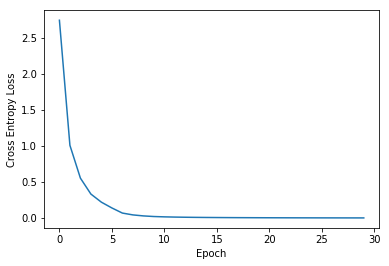

In [13]:
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.plot(avg_loss[None:])
plt.show()

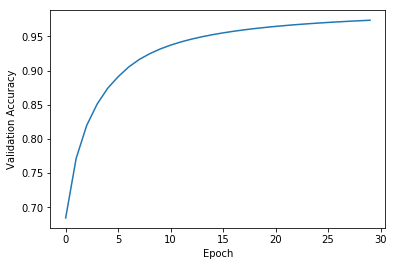

In [14]:
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.plot(validate_accuracy)
plt.show()

In [15]:
True_positives = np.diag(confusion_mat)
False_positives = np.sum(confusion_mat, axis=1) - True_positives
False_negatives = np.sum(confusion_mat, axis=0) - True_positives
Precision = True_positives / (True_positives + False_positives)
print("Precision:", Precision)
Recall = True_positives / (True_positives + False_negatives)
print("\nRecall:", Recall)
F_scores = (2*Precision*Recall) / (Recall+Precision)
print("\nF_scores:", F_scores)

Precision: [1.         1.         0.98979592 1.         1.         1.
 1.         0.97619048 0.89189189 1.         0.92       0.94736842
 0.98058252 0.96226415 1.         1.         0.97247706 1.
 0.98823529 0.98130841 0.97413793 1.         0.92222222 0.95505618
 0.99122807 1.         1.         1.         1.         1.
 1.         1.         0.99166667 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]

Recall: [0.99099099

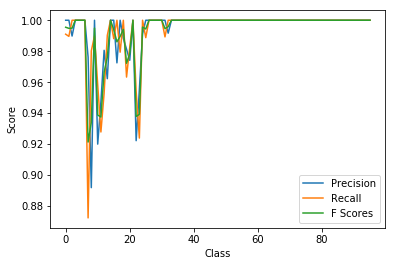

In [16]:
plt.plot(Precision, label='Precision')
plt.plot(Recall, label='Recall')
plt.plot(F_scores, label='F Scores')
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend()
plt.show()

In [17]:
np.savez_compressed('linev1-conmat.npz', cmat=confusion_mat)